# Test barycenter-based worm straightening

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from scipy.ndimage import geometric_transform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

import readers
from utils import pixel_dist_3d
from potmods import barycenter_sinkhorn

### Load frames

In [3]:
# Location of data
data_path = '/home/mn2822/Desktop/WormOT/data/synthetic/fast_3d/gmm_data_3d.h5'

# Number of frames to load
n_frames = 2

with readers.SyntheticReader(data_path) as reader:
    
    # TODO: Replace this hack with something more permanent
    frames = [reader.get_frame(3 * i) for i in range(n_frames)]

frame shape: (100, 50, 20)
num. pixels: 100000


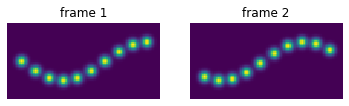

In [4]:
frame_shape = frames[0].shape
n_pixels = frame_shape[0] * frame_shape[1] * frame_shape[2]
print(f'frame shape: {frame_shape}')
print(f'num. pixels: {n_pixels}')

for i in range(n_frames):
    
    plt.subplot(1, n_frames, i + 1)
    plt.imshow(np.max(frames[i], 2).T);
    plt.title(f'frame {i + 1}')
    plt.axis('off')

### Downsample frames

In [5]:
scl = (2, 2, 2)
ds = [downscale_local_mean(f, scl) for f in frames]

frame shape (downsampled): (50, 25, 10)
num. pixels (downsampled): 12500


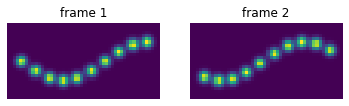

In [6]:
ds_shape = ds[0].shape
n_pixels_ds = ds_shape[0] * ds_shape[1] * ds_shape[2]
print(f'frame shape (downsampled): {ds_shape}')
print(f'num. pixels (downsampled): {n_pixels_ds}')

for i in range(n_frames):
    plt.subplot(1, n_frames, i + 1)
    plt.imshow(np.max(ds[i], 2).T);
    plt.title(f'frame {i + 1}')
    plt.axis('off')

### Compute barycenter

In [16]:
# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*ds_shape)
M = M_nn / np.median(M_nn)

# Entropic regularization parameter
reg = 1e-3

A = np.hstack([x.reshape(-1, 1) for x in ds])
bc_vec, u, v, K = barycenter_sinkhorn(A, M, reg)
bc_img = bc_vec.reshape(ds_shape)


(-0.5, 49.5, 24.5, -0.5)

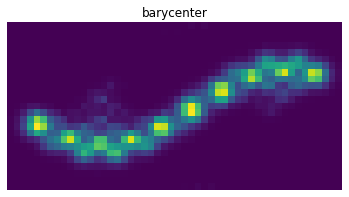

In [17]:
plt.imshow(np.max(bc_img, 2).T);
plt.title('barycenter')
plt.axis('off')

### Extract transport plan

In [18]:
# Frame
frame_idx = 1
frame = frames[frame_idx]

# Transport plan
u1 = u[:, frame_idx]
v1 = v[:, frame_idx]
P = np.diag(u1) @ K @ np.diag(v1)



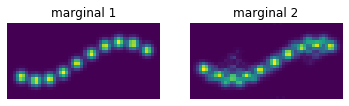

In [19]:
m1_vec = np.sum(P, axis=0)
m2_vec = np.sum(P, axis=1)

m1_img = m1_vec.reshape(ds_shape)
m2_img = m2_vec.reshape(ds_shape)

plt.subplot(121)
plt.imshow(np.max(m1_img, 2).T)
plt.axis('off')
plt.title('marginal 1')

plt.subplot(122)
plt.imshow(np.max(m2_img, 2).T)
plt.axis('off')
plt.title('marginal 2');

In [20]:
# Compute pushforward from barycenter to original worm
T = P / bc_vec.reshape(-1, 1)

# Get all pixel coordinates
nx, ny, nz = ds_shape
[xg, yg, zg] = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz))
grid_vals = np.hstack(
    (xg.reshape(-1, 1), yg.reshape(-1, 1), zg.reshape(-1, 1)))

t_vals = T @ grid_vals

In [21]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression(fit_intercept=True))
])
model.fit(grid_vals, t_vals)

beta = model.named_steps['linear'].coef_
alpha = model.named_steps['linear'].intercept_

In [22]:
def inv_map(coords):
    in_arr = np.array(coords).reshape(1, -1)
    out_arr = model.predict(in_arr)
    return tuple(out_arr.flatten())

t_frame = geometric_transform(frame, inv_map)

Text(0.5, 1.0, 'transformed')

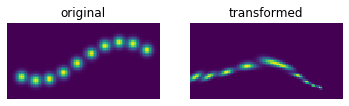

In [23]:
plt.subplot(121)
plt.imshow(np.max(frame, 2).T)
plt.axis('off')
plt.title('original')

plt.subplot(122)
plt.imshow(np.max(t_frame, 2).T)
plt.axis('off')
plt.title('transformed')